# Taller Práctico Clase 4: SVM y el Poder de los Kernels

**Objetivo:** En este notebook, aplicaremos los conceptos de Máquinas de Vectores de Soporte (SVM) para resolver un problema de clasificación no lineal. Compararemos el rendimiento de SVM con diferentes kernels frente a un modelo lineal como la Regresión Logística y visualizaremos sus fronteras de decisión para desarrollar una intuición profunda sobre su funcionamiento.

**Temas a cubrir:**
1.  Generación y visualización de un dataset no lineal.
2.  Entrenamiento de un modelo de Regresión Logística como base.
3.  Entrenamiento de SVM con kernel lineal, polinómico y RBF.
4.  Visualización interactiva de las fronteras de decisión.
5.  Análisis del impacto de los hiperparámetros `C` y `gamma`.

## 1. Preparación del Entorno e Importación de Librerías

Primero, importaremos todas las librerías que necesitaremos para nuestro análisis.

In [71]:
# Manipulación de datos
import numpy as np

# Scikit-Learn para datasets, modelos y preprocesamiento
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Plotly para visualizaciones interactivas
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

## 2. Generación y Exploración del Dataset

Para demostrar el poder de los kernels, necesitamos un dataset que no sea linealmente separable. `make_moons` de Scikit-Learn es perfecto para esto, ya que genera dos "medias lunas" entrelazadas.

In [ ]:
# Generamos el dataset
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)

# Dividimos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalamos las características. Es una buena práctica para SVM.
scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Visualicemos los datos de entrenamiento
fig = px.scatter(x=X_train[:, 0], y=X_train[:, 1], color=y_train.astype(str),
                 color_discrete_map={'0': 'blue', '1': 'red'},
                 title='Dataset de Entrenamiento (Moons)',
                 labels={'x': 'Característica 1', 'y': 'Característica 2'})
fig.update_layout(showlegend=False, height=600, width=800)
fig.show()

## 3. Comparación de Modelos y Fronteras de Decisión

Ahora vamos a entrenar nuestros modelos y, para cada uno, visualizaremos la frontera de decisión que aprende. Para ello, crearemos una función auxiliar que nos facilite el ploteo.

In [73]:
def plot_decision_boundary(model, X, y, title):
    """Función para visualizar la frontera de decisión de un modelo de clasificación en 2D."""
    # Creamos una malla de puntos para evaluar el modelo
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Predecimos sobre cada punto de la malla
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Creamos la figura
    fig = go.Figure()

    # Añadimos la superficie de decisión (contour plot)
    fig.add_trace(go.Contour(
        x=xx[0], y=yy[:, 0],
        z=Z, showscale=False,
        colorscale=['rgba(0,0,255,0.2)', 'rgba(255,0,0,0.2)'],
        line_width=0
    ))

    # Añadimos los puntos de datos
    fig.add_trace(go.Scatter(
        x=X[:, 0], y=X[:, 1], mode='markers',
        marker=dict(color=y, colorscale=['blue', 'red'], line=dict(width=1, color='DarkSlateGrey')),
        showlegend=False
    ))

    # Calculamos la precisión (accuracy)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)

    fig.update_layout(title=f'{title}<br>Accuracy: {acc:.4f}',
                      xaxis_title='Característica 1 (escalada)',
                      yaxis_title='Característica 2 (escalada)',
                      height=600, width=800,)
    return fig

### 3.1. Regresión Logística (Modelo Base)

In [74]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
fig = plot_decision_boundary(log_reg, X_train, y_train, 'Regresión Logística')
fig.show()

Como era de esperar, la Regresión Logística intenta separar los datos con una línea recta, fallando en capturar la estructura curva de las "lunas".

### 3.2. SVM con Kernel Lineal

In [75]:
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)
fig = plot_decision_boundary(svm_linear, X_train, y_train, 'SVM con Kernel Lineal')
fig.show()

El SVM lineal produce un resultado muy similar a la Regresión Logística. Ambos son modelos lineales y, por lo tanto, inadecuados para este problema.

### 3.3. SVM con Kernel Polinómico

In [76]:
svm_poly = SVC(kernel='poly', degree=3, random_state=42)
svm_poly.fit(X_train, y_train)
fig = plot_decision_boundary(svm_poly, X_train, y_train, 'SVM con Kernel Polinómico (grado 3)')
fig.show()

¡Mucho mejor! El kernel polinómico puede crear una frontera curva que se adapta mucho mejor a la forma de los datos. La precisión mejora un poco.

### 3.4. SVM con Kernel RBF (Radial Basis Function)

In [77]:
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)
fig = plot_decision_boundary(svm_rbf, X_train, y_train, 'SVM con Kernel RBF')
fig.show()

El kernel RBF, que es el más flexible y popular, logra la mejor separación. Crea una frontera suave y compleja que se ajusta casi perfectamente a la estructura de los datos, logrando la mayor precisión.

## 4. El Impacto de los Hiperparámetros `C` y `gamma`

En SVM, `C` y `gamma` (para el kernel RBF) son cruciales. Vamos a visualizar su efecto.

- **`C` (Parámetro de regularización):** Controla el trade-off entre un margen ancho y clasificar correctamente todos los puntos. Un `C` bajo crea un margen más ancho pero permite más violaciones (más simple, más sesgo). Un `C` alto crea un margen más estrecho, intentando clasificar todo correctamente (más complejo, más varianza).
- **`gamma`:** Define la influencia de un único ejemplo de entrenamiento. Un `gamma` bajo significa que un punto tiene una influencia lejana (frontera más suave). Un `gamma` alto significa que un punto tiene una influencia muy local (frontera puede ser muy irregular).

In [78]:
# Creamos una figura con subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "Bajo Gamma, Bajo C", "Alto Gamma, Bajo C",
    "Bajo Gamma, Alto C", "Alto Gamma, Alto C"
))

hyperparams = [(0.1, 1), (20, 1), (0.1, 2000), (20, 2000)]
plot_positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

for (gamma, C), pos in zip(hyperparams, plot_positions):
    # Entrenar modelo
    svm = SVC(kernel='rbf', gamma=gamma, C=C)
    svm.fit(X_train, y_train)
    
    # Crear malla
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    # Predecir en la malla
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Añadir trazas a la sub-figura
    fig.add_trace(go.Contour(x=xx[0], y=yy[:, 0], z=Z, showscale=False, colorscale=['rgba(0,0,255,0.2)', 'rgba(255,0,0,0.2)'], line_width=0), row=pos[0], col=pos[1])
    fig.add_trace(go.Scatter(x=X_train[:, 0], y=X_train[:, 1], mode='markers', marker=dict(color=y_train, colorscale=['blue', 'red'])), row=pos[0], col=pos[1])

fig.update_layout(height=800, width=800, title_text="Efecto de Hiperparámetros C y Gamma en Kernel RBF", showlegend=False)
fig.show()

## 5. Desafíos

1.  **Evaluar en el conjunto de test:** Todos los `accuracy` se calcularon sobre los datos de entrenamiento para visualizar el ajuste. Calcula la precisión de los 4 modelos principales (LogReg, SVM Lineal, Polinómico, RBF con valores por defecto) en el conjunto de `X_test`, `y_test`. ¿Cuál generaliza mejor?
2.  **Probar otros datasets:** Importa el dataset de `make_circles` de `sklearn.datasets`. ¿Cómo se comportan los diferentes kernels en este caso? ¿Y con `make_blobs` con 3 centros?
3.  **Ajuste fino:** Usando los plots de la sección 4 como guía, intenta encontrar "a mano" una combinación de `C` y `gamma` que te parezca que da el mejor resultado (un buen balance entre ajuste y suavidad de la frontera).

## 6. Ejercicios Propuestos

1.  **Interpretación del Margen:** En el SVM con kernel lineal, ¿cómo podrías identificar visualmente cuáles son los vectores de soporte? (Pista: son los puntos más cercanos a la línea de separación).

2.  **Kernel Polinómico y Grado:** Modifica el grado `degree` del `SVC(kernel='poly', ...)` a 1, 2, 5 y 10. Describe cómo cambia la complejidad de la frontera de decisión y el riesgo de sobreajuste (overfitting).

3.  **El rol de `coef0`:** En el kernel polinómico, el parámetro `coef0` controla cuánto influyen los polinomios de grado alto vs. los de grado bajo. Investiga y experimenta con este parámetro. ¿Qué efecto tiene en la frontera de decisión?

4.  **SVM para Regresión (SVR):** La librería `sklearn.svm` también contiene `SVR`. Investiga cómo funciona SVR. A diferencia de SVM para clasificación que intenta poner una "calle" vacía entre clases, SVR intenta que la mayor cantidad de puntos queden *dentro* de la "calle". Aplica SVR a un dataset de regresión simple.

5.  **Coste Computacional:** Aumenta el número de muestras en `make_moons` a 5000 y luego a 20000. Mide el tiempo de entrenamiento de la Regresión Logística y del SVM con kernel RBF usando `%%timeit` en la celda. ¿Qué observas sobre la escalabilidad de SVM?

6.  **Importancia del Escalado:** Vuelve a ejecutar el notebook pero esta vez, comenta las líneas donde se usa `StandardScaler`. ¿Qué impacto tiene en el rendimiento del SVM, especialmente con kernel RBF? ¿Por qué crees que ocurre esto? (Pista: el kernel RBF depende de distancias).

7.  **Creando un Kernel Personalizado:** La clase `SVC` de Scikit-Learn permite pasar una función como kernel. Define una función en Python que reciba dos vectores `X1` y `X2` y devuelva su producto punto (kernel lineal). Úsala para entrenar un SVM: `SVC(kernel=mi_kernel_lineal)`. Obs: el parametro debe ser una "callable" que reciba dos arrays y devuelva un escalar. ¿Cómo se compara con el SVM lineal de Scikit-Learn?

8.  **El parámetro `C` a fondo:** Crea un bucle que entrene varios SVM con kernel lineal pero con valores de `C` muy diferentes (ej. 0.01, 1, 100, 10000). Para cada uno, imprime el número de vectores de soporte (`model.n_support_`). ¿Qué relación observas entre el valor de `C` y la cantidad de vectores de soporte?

9.  **Aplicación a un problema real:** Carga el dataset de cáncer de mama de sklearn (`load_breast_cancer`). Como es un dataset con muchas características, no podrás visualizar la frontera de decisión. En su lugar, usa `GridSearchCV` de `sklearn.model_selection` para encontrar la mejor combinación de `C` y `gamma` para un SVM con kernel RBF. Compara su `accuracy` en el conjunto de test con el de una Regresión Logística.

----------------------------------------------------------------------

#### 1.  **Interpretación del Margen:** En el SVM con kernel lineal, ¿cómo podrías identificar visualmente cuáles son los vectores de soporte? (Pista: son los puntos más cercanos a la línea de separación).

`Respuesta`: son aquellos vectores que minimizan la distancia a la linea de separación.


------------------------------------------

#### 2.  **Kernel Polinómico y Grado:** Modifica el grado `degree` del `SVC(kernel='poly', ...)` a 1, 2, 5 y 10. Describe cómo cambia la complejidad de la frontera de decisión y el riesgo de sobreajuste (overfitting).

In [79]:
svm_poly = SVC(kernel='poly', degree=1, random_state=42)
svm_poly.fit(X_train, y_train)
fig = plot_decision_boundary(svm_poly, X_train, y_train, 'SVM con Kernel Polinómico (grado 1)')
fig.show()

`Respuesta (grado 1)`: un kernel polinómio de 1, es igual que SVM con Kernel Lineal. Las clases se separan por medio de una línea recta. Tiene cierta efectividad en la clasificación.

In [80]:
svm_poly = SVC(kernel='poly', degree=2, random_state=42)
svm_poly.fit(X_train, y_train)
fig = plot_decision_boundary(svm_poly, X_train, y_train, 'SVM con Kernel Polinómico (grado 2)')
fig.show()

`Respuesta (grado 2)`: un SVM polinómico de grado 2, genera una calle que separa los hiperplanos, con poco éxito en la clasificación.

In [81]:
svm_poly = SVC(kernel='poly', degree=5, random_state=42)
svm_poly.fit(X_train, y_train)
fig = plot_decision_boundary(svm_poly, X_train, y_train, 'SVM con Kernel Polinómico (grado 5)')
fig.show()

`Respuesta (grado 5)`: un SVM polinómico de grado 5 genera una linea curva que separa las clases. Es un poquito más efectiva que la polinomica de grado 1.

In [82]:
svm_poly = SVC(kernel='poly', degree=10, random_state=42)
svm_poly.fit(X_train, y_train)
fig = plot_decision_boundary(svm_poly, X_train, y_train, 'SVM con Kernel Polinómico (grado 10)')
fig.show()

`Respuesta (grado 10)`: una SVM polinómica de grado 10, genera diversas curvas de separación. También es poco efectiva.

-------------------------------

#### 3.  **El rol de `coef0`:** En el kernel polinómico, el parámetro `coef0` controla cuánto influyen los polinomios de grado alto vs. los de grado bajo. Investiga y experimenta con este parámetro. ¿Qué efecto tiene en la frontera de decisión?

`Respuesta`: 
1. Para polinómios de `grado bajo`, 
- Un coef0 alto tiende a disminuir la precisión, pero no mucho. Podemos decir que no tiene demasiado impacto.
- Un coef0 en ascenso, hace que la curva vaya tendiendo a linea recta.
2. Para polinómios de `grado alto`, 
- El cambio de coef0 es más evidente en estos modelos. Por ejemplo, para un grado 10, subiendo el coef0 apenas a 0.5, ya mejora notablemente la precisión.
- Aumentar el coef0 hace que la curva se suavice y se unifique. Si se eleva demasiado, también tiende a recta. 
- Es muy costosa su ejecución (para grado=10, coef0=100, corre arriba de 8 mins). 

-----------------------------------------------------

In [83]:
# svm_poly = SVC(kernel='poly', degree=10, random_state=42, coef0=50)
svm_poly = SVC(kernel='poly', degree=5, random_state=42, coef0=50)
svm_poly.fit(X_train, y_train)
fig = plot_decision_boundary(svm_poly, X_train, y_train, 'SVM con Kernel Polinómico (grado 10)')
fig.show()

--------------------------------

#### 4.  **SVM para Regresión (SVR):** La librería `sklearn.svm` también contiene `SVR`. Investiga cómo funciona SVR. A diferencia de SVM para clasificación que intenta poner una "calle" vacía entre clases, SVR intenta que la mayor cantidad de puntos queden *dentro* de la "calle". Aplica SVR a un dataset de regresión simple.

`Respuesta`: 

**Funcionamiento de SVR**
* Es para regresión. En lugar de buscar una frontera que divida las clases, SVR busca una función (recta o curva) que pase lo más cerca posible de los datos, permitiendo que la mayor cantidad de puntos queden dentro de una `calle` de ancho ε (epsilon). Los puntos fuera de esa calle son los que más influyen en el modelo (vectores de soporte).

**Diferencias con SVM**: 
* SVM es un modelo de que maximiza el margen entre las clases.
* SRV es un modelo que minimiza el error y solo penaliza los puntos que quedan por fuera de la calle.

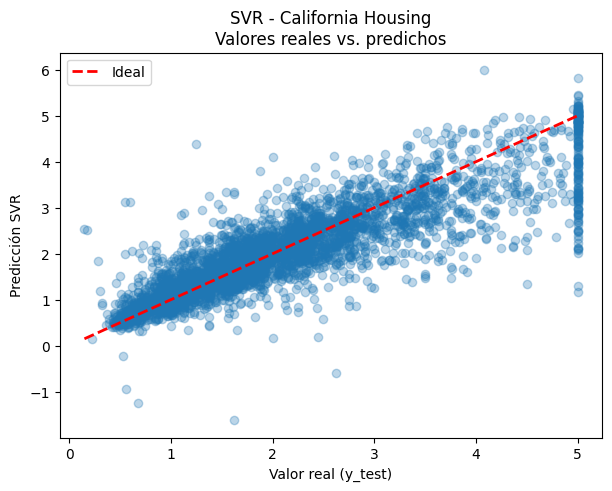

In [84]:
# importar librerias necesarias para SVR
from sklearn.svm import SVR
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# carga del dataset California Housing
california_X, california_y = fetch_california_housing(return_X_y=True, as_frame=True)

# división el dataset en entrenamiento y prueba
california_X_train, california_X_test, california_y_train, california_y_test = train_test_split(california_X, california_y, test_size=0.2, random_state=42)

# escalado y entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(california_X_train)
X_test_scaled = scaler.transform(california_X_test)
svr = SVR(kernel='rbf', C=100, epsilon=0.1) 
svr.fit(X_train_scaled, california_y_train) 
y_pred = svr.predict(X_test_scaled)

# Visualicemos los datos de entrenamiento
plt.figure(figsize=(7,5))
plt.scatter(california_y_test, y_pred, alpha=0.3)
plt.xlabel("Valor real (y_test)")
plt.ylabel("Predicción SVR")
plt.title("SVR - California Housing\nValores reales vs. predichos")
plt.plot([california_y_test.min(), california_y_test.max()],
         [california_y_test.min(), california_y_test.max()],
         'r--', lw=2, label="Ideal")
plt.legend()
plt.show()



-------------------

#### 5.  **Coste Computacional:** Aumenta el número de muestras en `make_moons` a 5000 y luego a 20000. Mide el tiempo de entrenamiento de la Regresión Logística y del SVM con kernel RBF usando `%%timeit` en la celda. ¿Qué observas sobre la escalabilidad de SVM?

`Respuesta`: 

In [85]:
# Generamos el dataset con 5000 muestras
X, y = make_moons(n_samples=5000, noise=0.25, random_state=42)

# Dividimos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalamos las características. Es una buena práctica para SVM.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualicemos los datos de entrenamiento
fig = px.scatter(x=X_train[:, 0], y=X_train[:, 1], color=y_train.astype(str),
                 color_discrete_map={'0': 'blue', '1': 'red'},
                 title='Dataset de Entrenamiento (Moons) 5000 muestras',
                 labels={'x': 'Característica 1', 'y': 'Característica 2'})
fig.update_layout(showlegend=False, height=600, width=800)
fig.show()

In [86]:
%%timeit
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)


2.15 ms ± 51.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
%%timeit
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train, y_train)

48.4 ms ± 598 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


----------------------------

#### 6.  **Importancia del Escalado:** Vuelve a ejecutar el notebook pero esta vez, comenta las líneas donde se usa `StandardScaler`. ¿Qué impacto tiene en el rendimiento del SVM, especialmente con kernel RBF? ¿Por qué crees que ocurre esto? (Pista: el kernel RBF depende de distancias).

`Respuesta`: 
- Sin escalado, SVM con RBF parece funcionar peor. El accurancy baja mucho y la frontera de descisión puede no distinguir bien las clases.

---------------------------

#### 7.  **Creando un Kernel Personalizado:** La clase `SVC` de Scikit-Learn permite pasar una función como kernel. Define una función en Python que reciba dos vectores `X1` y `X2` y devuelva su producto punto (kernel lineal). Úsala para entrenar un SVM: `SVC(kernel=mi_kernel_lineal)`. Obs: el parametro debe ser una "callable" que reciba dos arrays y devuelva un escalar. ¿Cómo se compara con el SVM lineal de Scikit-Learn?

`Respuesta`: 

In [88]:
# defino mi kernel personalizado
def my_kernel(X, Y):
    return np.dot(X, Y.T)

# entreno el SVM usando mi kernel personalizado
svm_custom = SVC(kernel=my_kernel, random_state=42)
svm_custom.fit(X_train, y_train)

# entreno el SVM usando el kernel estándar
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train, y_train)

# Evaluar ambos modelos
print("Accuracy kernel personalizado:", svm_custom.score(X_test, y_test))
print("Accuracy kernel lineal sklearn:", svm_linear.score(X_test, y_test))

Accuracy kernel personalizado: 0.87
Accuracy kernel lineal sklearn: 0.87


---------------------------

#### 8.  **El parámetro `C` a fondo:** Crea un bucle que entrene varios SVM con kernel lineal pero con valores de `C` muy diferentes (ej. 0.01, 1, 100, 10000). Para cada uno, imprime el número de vectores de soporte (`model.n_support_`). ¿Qué relación observas entre el valor de `C` y la cantidad de vectores de soporte?

`Respuesta`: 

In [90]:
valores_C = [0.01, 1, 100, 10000]

for C in valores_C:
    svm = SVC(kernel='linear', C=C, random_state=42)
    svm.fit(X_train, y_train)
    print(f"C={C}, >>> Vectores de soporte: {svm.n_support_}")  


C=0.01, >>> Vectores de soporte: [675 675]
C=1, >>> Vectores de soporte: [575 576]
C=100, >>> Vectores de soporte: [574 574]
C=10000, >>> Vectores de soporte: [574 574]


-----------------------

#### 9.  **Aplicación a un problema real:** Carga el dataset de cáncer de mama de sklearn (`load_breast_cancer`). Como es un dataset con muchas características, no podrás visualizar la frontera de decisión. En su lugar, usa `GridSearchCV` de `sklearn.model_selection` para encontrar la mejor combinación de `C` y `gamma` para un SVM con kernel RBF. Compara su `accuracy` en el conjunto de test con el de una Regresión Logística.

`Respuesta`:


In [91]:
# cargar el dataset de cáncer de mama
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()

from sklearn.model_selection import GridSearchCV

# encontrar la mejor combinación de C y gamma para un SVM con kernel RBF
X_cancer = cancer_data.data
y_cancer = cancer_data.target

# dividir el dataset en entrenamiento y prueba
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42)

# escalar las características
scaler_cancer = StandardScaler()
X_train_cancer = scaler_cancer.fit_transform(X_train_cancer)
X_test_cancer = scaler_cancer.transform(X_test_cancer)

# entrenar con SVM con kernel RBF
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_cancer, y_train_cancer)
y_pred_cancer = grid_search.predict(X_test_cancer)

# entrenar con Regresión Logística
log_reg_cancer = LogisticRegression(max_iter=10000, random_state=42)
log_reg_cancer.fit(X_train_cancer, y_train_cancer)  
y_pred_log_reg_cancer = log_reg_cancer.predict(X_test_cancer)

# comparar la precisión de ambos modelos
from sklearn.metrics import accuracy_score
accuracy_svm = accuracy_score(y_test_cancer, y_pred_cancer)
accuracy_log_reg = accuracy_score(y_test_cancer, y_pred_log_reg_cancer)

print(f"Precisión SVM con kernel RBF: {accuracy_svm:.4f}")
print(f"Precisión Regresión Logística: {accuracy_log_reg:.4f}")

Precisión SVM con kernel RBF: 0.9825
Precisión Regresión Logística: 0.9737
